# Train a BNN to classify MNIST

In [1]:
# for leonhard
import os
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
os.environ['XLA_FLAGS']

%load_ext autoreload
# Train a Bayesian neural network to classify MNIST using
# (parallel) Langevin dynamics
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
import sys
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/learning_particle_gradients/")
sys.path.append("../../experiments/")
import argparse
import matplotlib.pyplot as plt
import numpy as onp
import jax.numpy as jnp

from jax import jit, value_and_grad, vmap, random, grad
from tqdm import tqdm
import optax
import utils
import config as cfg
import jax.flatten_util
import mnist
import bnn
import metrics

import os
on_cluster = not os.getenv("HOME") == "/home/lauro"

# Config
key = random.PRNGKey(0)
EPOCHS = 1
BATCH_SIZE = 128
LEARNING_RATE = 5e-7  # 1e-6 too high!!
NUM_SAMPLES = 100
DISABLE_PROGRESS_BAR = False



# initialize set of parameters
key, subkey = random.split(key)
param_set = vmap(bnn.model.init, (0, None))(
    random.split(subkey, NUM_SAMPLES), mnist.train_images[:5])

sgld = utils.sgld(LEARNING_RATE)
sgld_state = sgld.init(param_set)

@jit
def sgld_step(particles, grads, sgld_state):
    """Update param_set elements in parallel using Langevin dynamics."""
    g, sgld_state = sgld.update(grads, sgld_state, particles)
    particles = optax.apply_updates(particles, g)
    aux = {
        "global_grad_norm": optax.global_norm(g),
    }
    return particles, sgld_state, aux

Loading data...


# Training with parallel Langevin dynamics

In [2]:
# training loop
rundata = {}
trajectories = []
accuracies = []
step_counter = 0

# dloss = jit(vmap(value_and_grad(bnn.loss), (0, None, None)))
dloss = jit(vmap(grad(bnn.loss), (0, None, None)))

In [3]:
bnn.loss?

In [10]:
n_train_steps = 422
for _ in tqdm(range(n_train_steps), disable=DISABLE_PROGRESS_BAR):
    step_counter += 1
    images, labels = next(mnist.training_batches)
#     losses, grads = dloss(param_set, images, labels)
    grads = dloss(param_set, images, labels)
    param_set, slgd_state, aux = sgld_step(param_set, grads, sgld_state)
#     aux.update({"loglikelihood": -losses.mean()})
    aux.update({"loss": vmap(bnn.loss, (0, None, None))(param_set, images, labels)})
    metrics.append_to_log(rundata, aux)
#     trajectories.append(vmap(lambda ps: jax.flatten_util.ravel_pytree(ps)[0])(param_set))

    if step_counter % 10 == 0:
        accuracies.append((step_counter, bnn.compute_acc(param_set)))
#         print(f"Step {step_counter}, Accuracy:", accuracies[-1])

100%|██████████| 422/422 [00:22<00:00, 18.80it/s]


In [5]:
losses.mean()

DeviceArray(22471872., dtype=float32)

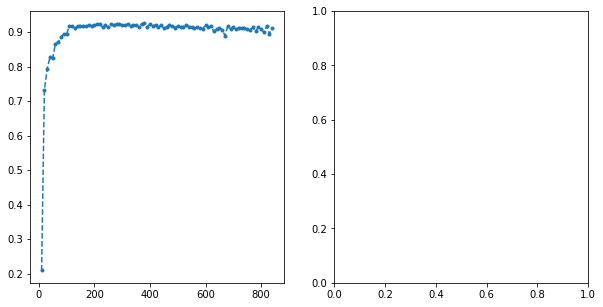

In [11]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs[0].plot(*zip(*accuracies), "--.")
# axs[1].plot(rundata['loglikelihood'], "--.");

In [17]:
# onp.save("trained_sgld.npy", vmap(bnn.ravel)(param_set))

In [15]:
accuracies[-1]

(840, DeviceArray(0.9118541, dtype=float32))

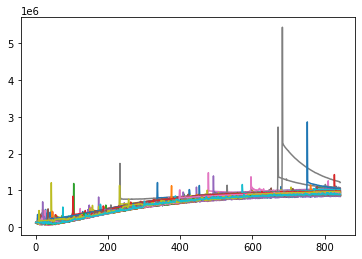

In [16]:
plt.plot(rundata['loss']);

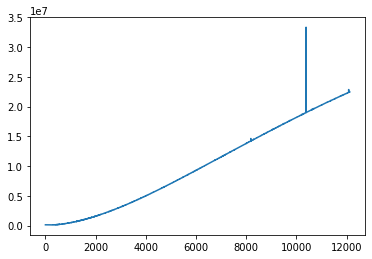

In [8]:
plt.plot(onp.array(rundata['loss']).mean(axis=1));

AxisError: axis 2 is out of bounds for array of dimension 1

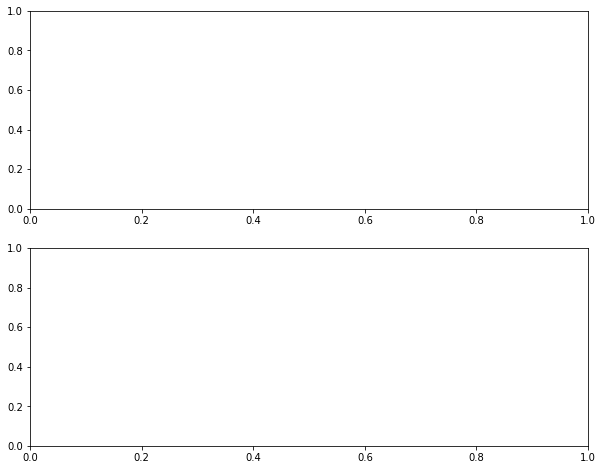

In [16]:
# visualize trajectory avg across dimensions (distinguish particles)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories_arr.mean(axis=2));  # avg across dims

ax = axs[1]
ax.plot(trajectories_arr[:, :, 0]);  # watch single param (aka single dimension)

AxisError: axis 1 is out of bounds for array of dimension 1

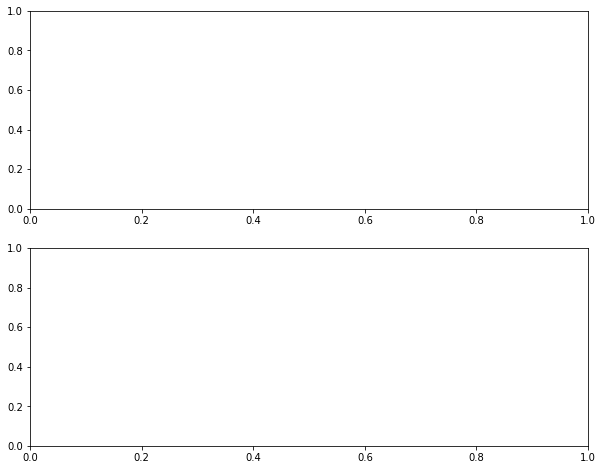

In [17]:
# visualize trajectory avg across particles (distinguish dims, ie parameters)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories_arr.mean(axis=1)); # avg across particles

ax = axs[1]
ax.plot(trajectories_arr[:, 10, :]); # watch single particle

# Classic (non-Bayesian) training
* Train a classifier using SGD. 
* To be consistent with the BNN approach, all parameters (including biases) are initialized as $N(0, 1/100^2)$ (ie the prior).
* The training loss is $L^2$-regularized, corresponding roughly to the maximum a posteriori estimator with the normal prior.

Note: works fine with networks as small as 2-layer conv with 4 channels per layer (loss decreases steadily and accuracy is ~0.92 after two epochs).

In [18]:
%autoreload

In [19]:
learning_rate = 1e-7
opt = optax.sgd(learning_rate)
# opt = utils.sgld(learning_rate)

@jit
def classic_step(params, opt_state, images, labels):
    step_loss, g = value_and_grad(bnn.loss)(params, images, labels)
    g, opt_state = opt.update(g, opt_state, params)
    return optax.apply_updates(params, g), opt_state, step_loss

@jit
def compute_accuracy(params):
    return bnn.accuracy(bnn.model.apply(params, mnist.val_images[:BATCH_SIZE]), mnist.val_labels[:BATCH_SIZE])


key, subkey = random.split(key)
params = bnn.model.init(subkey, mnist.train_images[:2])
opt_state = opt.init(params)

ls = []
ces = []
accs = []
trajectory = []
step_count = 0

pflat = jax.flatten_util.ravel_pytree(params)[0]
pflat.shape

(4594,)

In [23]:
for _ in tqdm(range(20000)):
    step_count += 1
    images, labels = next(mnist.training_batches)
    params, opt_state, step_loss = classic_step(params, opt_state, images, labels)

    ls.append(step_loss)

    if step_count % 100 == 0:
        trajectory.append(jax.flatten_util.ravel_pytree(params)[0])
        current_acc = compute_accuracy(params)
        accs.append((step_count, current_acc))

100%|██████████| 20000/20000 [00:16<00:00, 1199.36it/s]


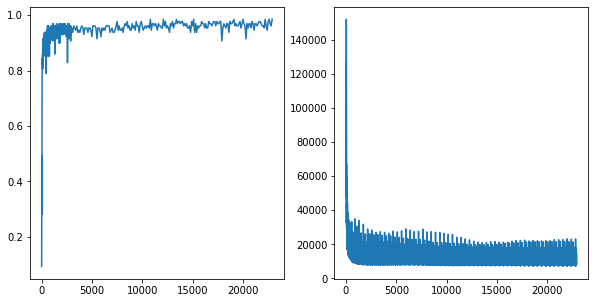

In [24]:
# 4.5k params
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs[0].plot(*zip(*accs))
axs[1].plot(ls)

In [29]:
trajectory_arr = onp.array(trajectory)

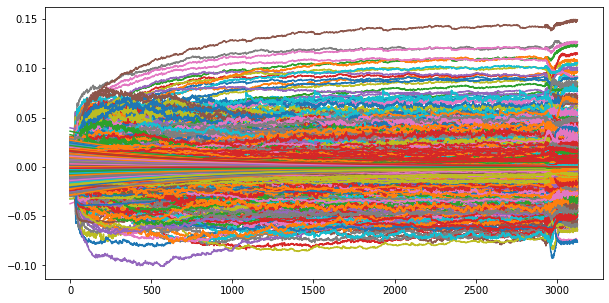

In [30]:
# visualize trajectory of each parameter
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(trajectory_arr);